In [3]:
import numpy as np
import pandas as pd
data_map = {
    "luna": pd.read_csv("data/terra-luna.csv", skip_blank_lines=True),
    "ust": pd.read_csv("data/terrausd.csv"),
    "bitcoin": pd.read_csv("data/bitcoin.csv"),
    "solana": pd.read_csv("data/solana.csv"),
    "usdc": pd.read_csv("data/usd-coin.csv"),
    "tether": pd.read_csv("data/tether.csv")
}
data_array = []
for key in data_map:
    data_array.append(data_map[key].rename({"price": key}, axis=1))

data_all = pd.concat(data_array, axis=1)
data_all = data_all.loc[:,~data_all.columns.duplicated()] # remove duplicate columns
data_all = data_all.dropna() # drop rows that have any blank values
data_all.head()

,timestamp,date,luna,ust,bitcoin,solana,usdc,tether
0,1.651853e+09,2022-05-06T12:00:00,79.97,0.9998,36105.48,81.65,1.0003,0.999994
1,1.651854e+09,2022-05-06T12:15:00,79.88,0.9998,35974.68,81.45,1.0003,1.000064
2,1.651855e+09,2022-05-06T12:30:00,80.08,0.9998,35973.96,81.83,1.0002,1.000021
3,1.651856e+09,2022-05-06T12:45:00,80.24,0.9999,36106.82,81.95,1.0003,1.000025
4,1.651856e+09,2022-05-06T13:00:00,80.67,0.9998,36123.75,82.41,1.0003,1.000023


In [4]:
# add UST categories column, so we split the data evenly
data_all["ust_cat"] = pd.cut(data_all["ust"], bins=[0.0, 0.5, 0.75, 0.9, 1.1], labels=[1, 2, 3, 4])

from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data_all, data_all["ust_cat"]):
    data_train = data_all.loc[train_index]
    data_test = data_all.loc[test_index]

print("train size", data_train.size)
print("test size", data_test.size)

train size 7740
test size 1944


<AxesSubplot:xlabel='luna', ylabel='ust'>

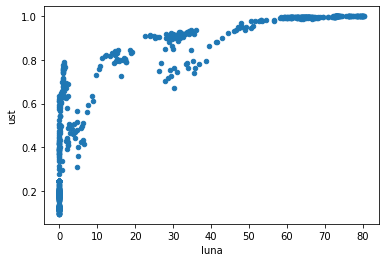

In [6]:
data_train.plot(kind="scatter", x="luna", y="ust")

array([[<AxesSubplot:xlabel='ust', ylabel='ust'>,
        <AxesSubplot:xlabel='bitcoin', ylabel='ust'>,
        <AxesSubplot:xlabel='solana', ylabel='ust'>,
        <AxesSubplot:xlabel='usdc', ylabel='ust'>],
       [<AxesSubplot:xlabel='ust', ylabel='bitcoin'>,
        <AxesSubplot:xlabel='bitcoin', ylabel='bitcoin'>,
        <AxesSubplot:xlabel='solana', ylabel='bitcoin'>,
        <AxesSubplot:xlabel='usdc', ylabel='bitcoin'>],
       [<AxesSubplot:xlabel='ust', ylabel='solana'>,
        <AxesSubplot:xlabel='bitcoin', ylabel='solana'>,
        <AxesSubplot:xlabel='solana', ylabel='solana'>,
        <AxesSubplot:xlabel='usdc', ylabel='solana'>],
       [<AxesSubplot:xlabel='ust', ylabel='usdc'>,
        <AxesSubplot:xlabel='bitcoin', ylabel='usdc'>,
        <AxesSubplot:xlabel='solana', ylabel='usdc'>,
        <AxesSubplot:xlabel='usdc', ylabel='usdc'>]], dtype=object)

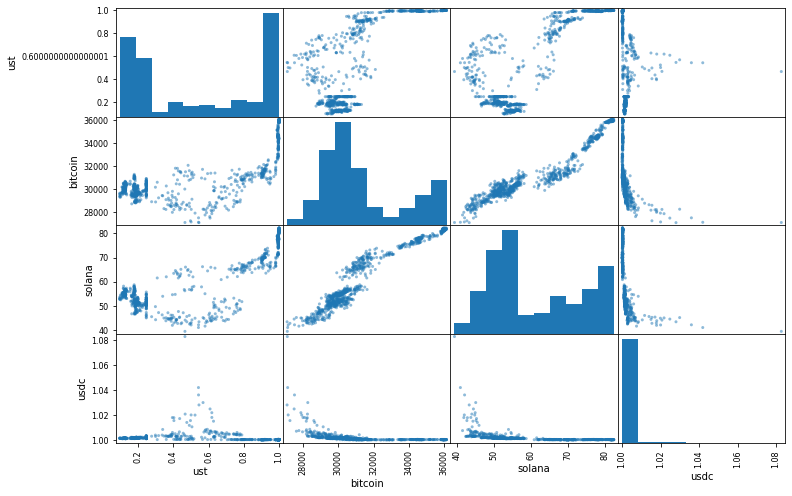

In [7]:
from pandas.plotting import scatter_matrix
attributes = ["ust", "bitcoin", "solana", "usdc"]
scatter_matrix(data_train[attributes], figsize=(12, 8))

In [9]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

data = data_train.drop(["date", "ust", "ust_cat"], axis=1)
data_label = data_train["ust"].copy()
#data_num = data.drop("usdc", axis=1)
#cat_attributes = ["usdc"]
#full_pipeline = ColumnTransformer([
#  ('cat', OneHotEncoder(), cat_attributes)
#])
#data_prepared = full_pipeline.fit_transform(data)

In [10]:
# LINEAR MODEL

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

linear = LinearRegression()
linear.fit(data, data_label)

scores = cross_val_score(linear, data, data_label)
print("Score:",scores.mean())

example_data = data.iloc[:5]
example_label = data_label.iloc[:5]
print("Predictions:", linear.predict(example_data))
print("Labels:", list(example_label))

Score: 0.9454911748506989
Predictions: [0.99864148 0.27319869 0.98086185 1.06460192 0.15116884]
Labels: [0.9985, 0.245779, 0.95, 0.9996, 0.1760796804750948]


In [11]:
# RANDOM FOREST MODEL
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor()
forest.fit(data, data_label)

scores = cross_val_score(forest, data, data_label)
print("Score:",scores.mean())
print("Predictions:", forest.predict(example_data))
print("Labels:", list(example_label))

Score: 0.9961317188970391
Predictions: [0.998532   0.245779   0.94605    0.999652   0.17658986]
Labels: [0.9985, 0.245779, 0.95, 0.9996, 0.1760796804750948]


In [12]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [1, 2, 4]}
]

forest2 = RandomForestRegressor()
grid_search = GridSearchCV(forest2, param_grid, cv=5, return_train_score=True)
grid_search.fit(data, data_label)
scores = cross_val_score(forest, data, data_label)
print(grid_search.best_params_)
final_model = grid_search.best_estimator_

{'max_features': 4, 'n_estimators': 30}


In [13]:
from sklearn.metrics import mean_absolute_error

data_test_X = data_test.drop(["date", "ust", "ust_cat"], axis=1)
data_test_Y = data_test["ust"].copy()
test_predictions = final_model.predict(data_test_X)
mean_absolute_error(data_test_Y, test_predictions)

0.008912148254106043

In [14]:
# predict if bull run instead of crash
my_test_data = pd.DataFrame(np.array([[1.651853e+09, 200, 60000.0, 200, 1.0, 1.0]]),
                            columns=['timestamp', 'luna', 'bitcoin', 'solana', 'usdc', 'tether'])
final_model.predict(my_test_data)

array([0.99980667])